In [2]:
from wsdb_query import *

In [38]:
bdf=pd.DataFrame(sqlutil.get('''
with t as (select * from leigh_smith.virac2_rc1
where (l>359. or l<1.) and abs(b)<1 and abs(b)>0.6)
select * from t where phot_ks_mean_mag>11 
and (phot_ks_mean_mag-1.3*(phot_h_mean_mag-phot_ks_mean_mag-0.1)>12.0)
and (phot_ks_mean_mag-1.3*(phot_h_mean_mag-phot_ks_mean_mag-0.1)<14.0)
limit 10000000
''', **wsdb_kwargs))
# and duplicate=0 and astfit_params=5

In [7]:
from astropy.coordinates import SkyCoord
import astropy.units as u
sk = SkyCoord(ra=bdf['ra']*u.deg,dec=bdf['dec']*u.deg,
              pm_ra_cosdec=bdf['pmra']*u.mas/u.yr, 
              pm_dec=bdf['pmdec']*u.mas/u.yr,frame='icrs')
gl=sk.transform_to('galactic')

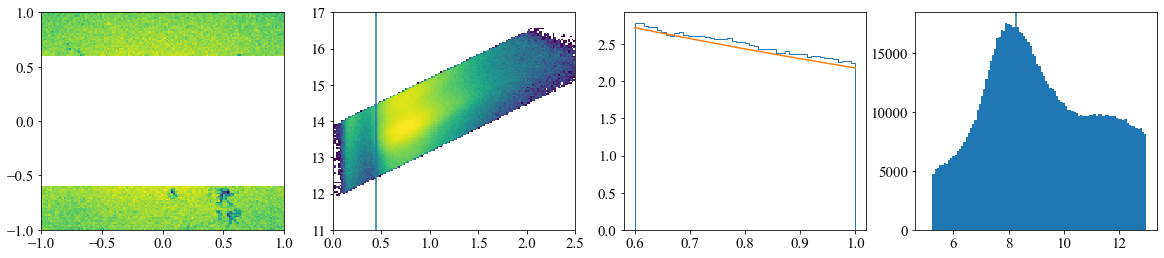

In [73]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
f,a=plt.subplots(1,4,figsize=[20,4])
plt.sca(a[0])
plt.hist2d(bdf['l']-360.*(bdf['l']>180.),bdf['b'],
           range=[[-1.,1.],[-1.,1.]],bins=140,norm=LogNorm());
plt.sca(a[1])
plt.hist2d(bdf['phot_h_mean_mag']-bdf['phot_ks_mean_mag'],bdf['phot_ks_mean_mag'],
           range=[[0.,2.5],[11.,17.]],bins=140,norm=LogNorm());
plt.axvline(0.45)
plt.sca(a[2])
plt.hist(np.abs(bdf['b']),bins=50,density=True,histtype='step');
xx = np.linspace(0.6,1.)
plt.plot(xx, 3.8*np.exp(-xx/1.8))
plt.sca(a[3])
dist = np.power(10.,0.2*(-1.3*(bdf['phot_h_mean_mag']-bdf['phot_ks_mean_mag']-0.1)+bdf['phot_ks_mean_mag']+1.6)-2)
plt.hist(dist,
         range=[5,13],bins=100);
plt.axvline(8.275)

In [34]:
test = bdf.copy()
test['pmra'] += np.random.normal(0.,test['pmra_error'])
test['pmdec'] += np.random.normal(0.,test['pmdec_error'])
sk = SkyCoord(ra=test['ra']*u.deg,dec=test['dec']*u.deg,
              pm_ra_cosdec=test['pmra']*u.mas/u.yr, 
              pm_dec=test['pmdec']*u.mas/u.yr,frame='icrs')
gl_test=sk.transform_to('galactic')

In [75]:
from kde import KDE_fft_ND
fltr = (bdf['phot_h_mean_mag']-bdf['phot_ks_mean_mag']>0.45)
kde = KDE_fft_ND(np.vstack([gl.pm_l_cosb.value,gl.pm_b.value]).T[fltr],gridsize='auto')
kde_test = KDE_fft_ND(np.vstack([gl_test.pm_l_cosb.value,gl_test.pm_b.value]).T[fltr],gridsize='auto')

Text(0, 0.5, 'pm_b (mas/yr)')

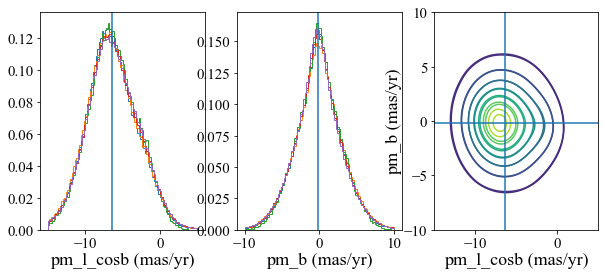

In [76]:
import matplotlib.pyplot as plt
f,a=plt.subplots(1,3,figsize=[10,4])
plt.sca(a[0])
plt.hist(gl.pm_l_cosb.value[(np.abs(gl.b.deg)>0.9)&fltr],range=[-15,5],bins=100,histtype='step',density=True);
plt.hist(gl_test.pm_l_cosb.value[(np.abs(gl_test.b.deg)>0.9)&fltr],range=[-15,5],bins=100,histtype='step',density=True);

plt.hist(gl.pm_l_cosb[(np.abs(gl.b.deg)>0.9)&fltr&(bdf['pmra_error']<0.5)],range=[-15,5],bins=100,histtype='step',density=True);
plt.hist(gl.pm_l_cosb[(np.abs(gl.b.deg)>0.7)&(np.abs(gl.b.deg)<0.9)&fltr],range=[-15,5],bins=100,histtype='step',density=True);
plt.hist(gl.pm_l_cosb[(np.abs(gl.b.deg)<0.7)&fltr],range=[-15,5],bins=100,histtype='step',density=True);
plt.axvline(-6.379)
plt.xlabel('pm_l_cosb (mas/yr)')

plt.sca(a[1])
plt.hist(gl.pm_b.value[(np.abs(gl.b.deg)>0.9)&fltr],range=[-10,10],bins=100,histtype='step',density=True);
plt.hist(gl_test.pm_b.value[(np.abs(gl_test.b.deg)>0.9)&fltr],range=[-10,10],bins=100,histtype='step',density=True);

plt.hist(gl.pm_b[(np.abs(gl.b.deg)>0.9)&fltr&(bdf['pmra_error']<0.5)],range=[-10,10],bins=100,histtype='step',density=True);
plt.hist(gl.pm_b[(np.abs(gl.b.deg)>0.7)&(np.abs(gl.b.deg)<0.9)&fltr],range=[-10,10],bins=100,histtype='step',density=True);
plt.hist(gl.pm_b[(np.abs(gl.b.deg)<0.7)&fltr],range=[-10,10],bins=100,histtype='step',density=True);
plt.axvline(-7.25/4.74/8.275)
plt.xlabel('pm_b (mas/yr)')

plt.sca(a[2])
x,y=np.meshgrid(np.linspace(-15,5,100),np.linspace(-10,10,100))
plt.contour(x,y,kde(np.vstack([x.flatten(),y.flatten()]).T).reshape(x.shape))
plt.contour(x,y,kde_test(np.vstack([x.flatten(),y.flatten()]).T).reshape(x.shape))
plt.axvline(-6.41)
plt.axhline(-7.25/4.74/8.275)
plt.xlabel('pm_l_cosb (mas/yr)')
plt.ylabel('pm_b (mas/yr)')

In [78]:
bdf['pml'] = gl.pm_l_cosb.value
bdf['pmb'] = gl.pm_b.value
bdf[['pml','pmb']][fltr].to_csv('background_bulge.csv')

In [65]:
import pandas as pd
mira = pd.read_csv('final_nsd_mira_full_cols.csv')
selection = (mira['amplitude']>0.4)&(mira['unreliable']==0)&(np.abs(mira['b'])<0.4)
miraS = mira[selection].reset_index(drop=True)
print(len(miraS))

1187


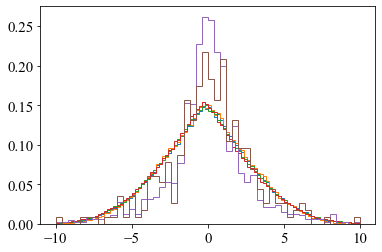

In [72]:
import matplotlib.pyplot as plt
plt.hist(gl.pm_b[(np.abs(gl.b.deg)>0.9)&fltr],range=[-10,10],bins=100,histtype='step',density=True);
plt.hist(gl.pm_b[(np.abs(gl.b.deg)>0.9)&fltr&(bdf['pmra_error']<0.5)],range=[-10,10],bins=100,histtype='step',density=True);
plt.hist(gl.pm_b[(np.abs(gl.b.deg)>0.7)&(np.abs(gl.b.deg)<0.9)&fltr],range=[-10,10],bins=100,histtype='step',density=True);
plt.hist(gl.pm_b[(np.abs(gl.b.deg)<0.7)&fltr],range=[-10,10],bins=100,histtype='step',density=True);
# xx = np.linspace(-10,10,1000)
# sg = 100.
# plt.plot(xx, np.exp(-(xx+10./4.74/8.275)**2/2./(sg/4.74/8.275)**2)/np.sqrt(2.*np.pi*(sg/4.74/8.275)**2))


plt.hist(miraS['pmb'],range=[-10,10],density=True,bins=50,histtype='step');
plt.hist(miraS['pmb'][miraS['period']<240],range=[-10,10],density=True,bins=50,histtype='step');

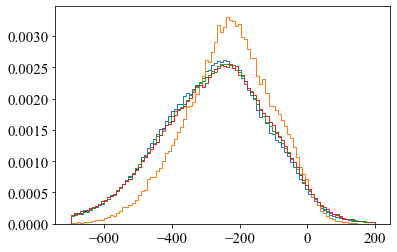

In [15]:
import matplotlib.pyplot as plt
plt.hist((dist*gl.pm_l_cosb*4.74)[(np.abs(gl.b.deg)>0.9)&fltr],range=[-700,200],bins=100,histtype='step',density=True);
plt.hist((dist*gl.pm_l_cosb*4.74)[(np.abs(gl.b.deg)>0.9)&fltr&(bdf['pmra_error']<0.5)],range=[-700,200],bins=100,histtype='step',density=True);
plt.hist((dist*gl.pm_l_cosb*4.74)[(np.abs(gl.b.deg)>0.7)&(np.abs(gl.b.deg)<0.9)&fltr],range=[-700,200],bins=100,histtype='step',density=True);
n2,b2,p=plt.hist((dist*gl.pm_l_cosb*4.74)[(np.abs(gl.b.deg)<0.7)&fltr],range=[-700,200],bins=100,histtype='step',density=True);
# xx = np.linspace(-350,350,1000)
# sg = 100.
# plt.plot(xx, np.exp(-(xx+10.)**2/2./(sg)**2)/np.sqrt(2.*np.pi*(sg)**2))

In [667]:
def logL(data, params):
    
    # Ndata, Ncompts, 2, 2
    
    diag = params['std_pm'][:,np.newaxis,:]*np.eye(2)
    cov = jnp.numpy.matmul(jnp.numpy.matmul(diag, params['correlation']), diag)
    inv_cov_p =  jnp.numpy.linalg.inv(data['pm_cov'][:,np.newaxis,:,:]+cov[np.newaxis,:,:,:])
    X_mu = (data['pm'][:,jnp.numpy.newaxis]-params['mean_pm'][jnp.numpy.newaxis,:])
    
    mix = jnp.numpy.cumsum(params['mix_unnorm'])
    mix = mix/jnp.numpy.sum(mix)
    
    return jnp.scipy.special.logsumexp(
               jnp.numpy.log(mix[jnp.numpy.newaxis,:])
               -.5*jnp.numpy.sum(X_mu * jnp.numpy.matmul(inv_cov_p, X_mu[:,:,:,jnp.numpy.newaxis])[:,:,:,0],axis=-1)
               +.5*jnp.numpy.log(jnp.numpy.linalg.det(inv_cov_p)),
           axis=1)


def logL_uncorrelated_cov(data, params):
    
    # Ndata, Ncompts, 2, 2
    
    cov = params['std_pm'][:,np.newaxis,:]**2*np.eye(2)
    inv_cov_p =  jnp.numpy.linalg.inv(data['pm_cov'][:,np.newaxis,:,:]+cov[np.newaxis,:,:,:])
    X_mu = (data['pm'][:,jnp.numpy.newaxis]-params['mean_pm'][jnp.numpy.newaxis,:])
    
    mix = jnp.numpy.cumsum(params['mix_unnorm'])
    mix = mix/jnp.numpy.sum(mix)
    
    return jnp.scipy.special.logsumexp(
               jnp.numpy.log(mix[jnp.numpy.newaxis,:])
               -.5*jnp.numpy.sum(X_mu * jnp.numpy.matmul(inv_cov_p, X_mu[:,:,:,jnp.numpy.newaxis])[:,:,:,0],axis=-1)
               +.5*jnp.numpy.log(jnp.numpy.linalg.det(inv_cov_p)),
           axis=1)


FLTR =(np.abs(gl.b.deg)>0.99)&fltr
print(np.count_nonzero(FLTR))

data = {'pm':jax.numpy.array(
            np.vstack([gl.pm_l_cosb.value[FLTR],
                       gl.pm_b.value[FLTR]]).T),
        'pm_cov':jax.numpy.array(
                np.vstack([
                bdf['pmra_error'].values[FLTR]**2,
                np.zeros(np.count_nonzero(FLTR)),
                np.zeros(np.count_nonzero(FLTR)),
                bdf['pmra_error'].values[FLTR]**2]
                ).T.reshape(np.count_nonzero(FLTR),2,2)
        )
    }

Ncomponents = 5
## Define parameters
parameters = {
              'mean_pm':numpyro.distributions.Normal(-6,5).expand([Ncomponents,2]),
              'std_pm':numpyro.distributions.HalfNormal(10).expand([Ncomponents,2]),
              # 'correlation':numpyro.distributions.LKJ(dimension=2,concentration=1).expand([Ncomponents]),
              'mix_unnorm':numpyro.distributions.HalfNormal(1).expand([Ncomponents])
             }

model = numpyro_model(logL_uncorrelated_cov, parameters, data)
model.run_mcmc(num_warmup=50, num_samples=50)

12899


sample: 100%|█████| 100/100 [13:10<00:00,  7.91s/it, 1023 steps of size 9.29e-03. acc. prob=0.90]


In [678]:
.5*np.diff(np.nanpercentile(random_draw(mix, means_, stds_),[16,84],axis=0))

array([[3.31806145],
       [2.94340982]])

In [669]:
print(np.count_nonzero((np.abs(gl.b.deg)>0.9)&fltr), np.count_nonzero(FLTR))

135650 12899


In [670]:
def random_draw(weights, means, stds, Ns=10000):
    draw = np.unique(np.random.choice(np.arange(len(means)), Ns, p=weights), return_counts=True)
    draw_ = np.zeros(len(means),dtype=np.int64)
    for i,d in zip(*draw):
        draw_[i]=d
    return np.concatenate([
        np.random.multivariate_normal(m, np.diag(s**2), d) for m,s,d in zip(means,stds,draw_)
    ])
    

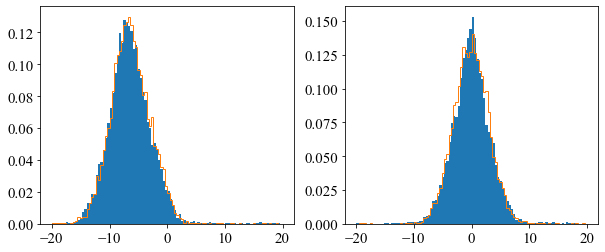

In [671]:
from scipy.special import logsumexp

mix=np.cumsum(np.nanmedian(model.samples()['mix_unnorm'].to_py(),axis=0))
mix /= np.sum(mix)
means_ = np.nanmedian(model.samples()['mean_pm'].to_py(), axis=0)
stds_ = np.nanmedian(model.samples()['std_pm'].to_py(), axis=0)

f,a=plt.subplots(1,2,figsize=[10,4])
plt.sca(a[0])
plt.hist(data['pm'].to_py()[:,0],bins=100,range=[-20,20],density=True);
# mix *= 0.
# mix[0]=1.
plt.hist(random_draw(mix, means_, stds_)[:,0],bins=100,range=[-20,20],density=True,histtype='step');
plt.sca(a[1])
plt.hist(data['pm'].to_py()[:,1],bins=100,range=[-20,20],density=True);
plt.hist(random_draw(mix, means_, stds_)[:,1],bins=100,range=[-20,20],density=True,histtype='step');
# plt.semilogy()

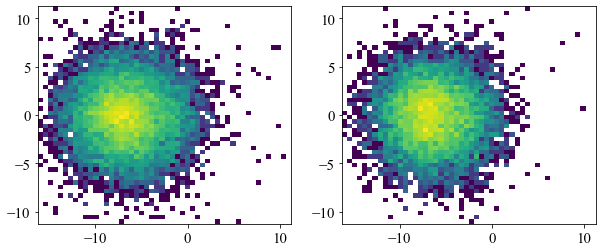

In [672]:
f,a=plt.subplots(1,2,figsize=[10,4])
plt.sca(a[0])
plt.hist2d((gl.pm_l_cosb.value)[FLTR],
           (gl.pm_b.value)[FLTR],
           range=[[-650/8./5.,450/8./5.],[-450/8./5.,450/8./5.]],label='0.9<|b|<1.1',bins=50,norm=LogNorm());
plt.sca(a[1])
XY=random_draw(mix, means_, stds_)
X,Y=XY[:,0],XY[:,1]
plt.hist2d(X,Y,
           range=[[-650/8./5.,450/8./5.],[-450/8./5.,450/8./5.]],label='0.9<|b|<1.1',bins=50,norm=LogNorm());


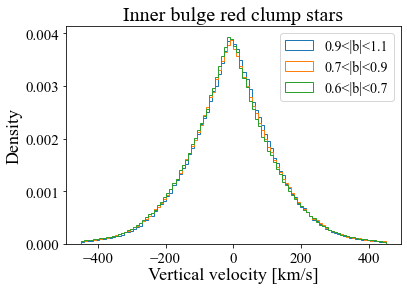

In [23]:
import matplotlib.pyplot as plt
plt.title('Inner bulge red clump stars',fontsize=20)
plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)>0.9)&fltr],range=[-450,450],label='0.9<|b|<1.1',bins=100,histtype='step',density=True);
# plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)>0.9)&fltr&(bdf['pmra_error']<0.5)],range=[-450,450],bins=100,histtype='step',density=True);
plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)>0.7)&(np.abs(gl.b.deg)<0.9)&fltr],label='0.7<|b|<0.9',range=[-450,450],bins=100,histtype='step',density=True);
n,b,p=plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)<0.7)&fltr],label='0.6<|b|<0.7',range=[-450,450],bins=100,histtype='step',density=True);

plt.xlabel('Vertical velocity [km/s]')
plt.ylabel('Density')
plt.legend()
# xx = np.linspace(-350,350,1000)
# sg = 100.
# plt.plot(xx, np.exp(-(xx+10.)**2/2./(sg)**2)/np.sqrt(2.*np.pi*(sg)**2))

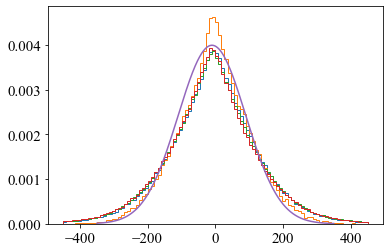

In [24]:
import matplotlib.pyplot as plt
plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)>0.9)&fltr],range=[-450,450],bins=100,histtype='step',density=True);
plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)>0.9)&fltr&(bdf['pmra_error']<0.5)],range=[-450,450],bins=100,histtype='step',density=True);
plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)>0.7)&(np.abs(gl.b.deg)<0.9)&fltr],range=[-450,450],bins=100,histtype='step',density=True);
n,b,p=plt.hist((dist*gl.pm_b*4.74)[(np.abs(gl.b.deg)<0.7)&fltr],range=[-450,450],bins=100,histtype='step',density=True);
xx = np.linspace(-350,350,1000)
sg = 100.
plt.plot(xx, np.exp(-(xx+10.)**2/2./(sg)**2)/np.sqrt(2.*np.pi*(sg)**2))

In [103]:
from scipy.ndimage import gaussian_filter1d
np.savetxt('bulge_background.dat',np.vstack([.5*(b[1:]+b[:-1]),gaussian_filter1d(n,1.)]).T)

In [108]:
from scipy.ndimage import gaussian_filter1d
np.savetxt('bulge_background_l.dat',np.vstack([.5*(b2[1:]+b2[:-1]),gaussian_filter1d(n2,1.)]).T)